In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
data = np.load('mnist_train_small.npy')

In [35]:
X = data[:,1:]
y = data[:,0]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=42)

In [37]:
X.shape,y.shape

((19999, 784), (19999,))

In [6]:
class Dense_Layer:
    def __init__(self,ninputs,nneurons):
        # Initialising weights and biases
        self.weights = 0.01 * np.random.randn(ninputs,nneurons)
        self.biases = np.zeros((1,nneurons))
        
    # Forward Propagation    
    def forward(self,inputs):
        self.output = np.dot(inputs,self.weights) + self.biases
        self.inputs = inputs
    
    # Backpropagation
    def backward(self,dvalues):
        self.dinputs = np.dot(dvalues,self.weights.T)
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)

In [7]:
class Activation_Relu:
    def forward(self,inputs):
        self.output = np.maximum(0,inputs)
        self.inputs = inputs
    
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        

In [8]:
class Activation_Softmax:
    def forward(self,inputs,y_true):
        expvals = np.exp(inputs - np.max(inputs, axis=1,
        keepdims=True) )
        self.output = expvals/np.sum(expvals,axis=1,keepdims=True)

In [9]:
class CrossEntropyLoss:
    def calculate(self,y_pred,y_true):
        # Turning one hot encoded values into sparse vectors
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true,axis=1)
        
        # Clipping to prevent log with 0
        ypred = np.clip(y_pred,1e-7,1-1e-7)
        
        return np.mean(-np.log(y_pred[range(len(y_pred)),y_true]))
    


In [10]:
class Activation_softmax_cross_entropy:
    def __init__(self):
        self.activation = Activation_Softmax()
        self.lossfunc = CrossEntropyLoss()
    
    def forward(self,inputs,y_true):
        self.activation.forward(inputs,y_true)
        self.output = self.activation.output
        return self.lossfunc.calculate(self.output,y_true)
    
    def backward(self,dvalues,y_true):
        samples = len(y_true)
        
        # Turning one hot encoded arrays to sparse vectors
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true,axis=1)
        
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples),y_true] -= 1
        
        self.dinputs/=samples

In [11]:
class Adam_Optimizer:
    def __init__(self,lr=0.001,decay_rate=0,epsilon= 1e-7,beta1=0.9,beta2=0.999):
        self.initiallr = lr
        self.currentlr = lr
        self.decay_rate = decay_rate
        self.iterations = 0
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
    
    def pre_update(self):
        self.currentlr = self.initiallr * (1/(1+(self.decay_rate * self.iterations)))

    def update_params(self,layer):
        
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            layer.weight_momentum = np.zeros_like(layer.weights)
            layer.bias_momentum = np.zeros_like(layer.biases)
            
        layer.weight_momentum = self.beta1 * layer.weight_momentum + (1-self.beta1) * layer.dweights
        layer.bias_momentum = self.beta1 * layer.bias_momentum + (1 - self.beta1) * layer.dbiases
        
        layer.weight_momentum_prime = layer.weight_momentum / (1 - self.beta1 ** (self.iterations + 1))
        layer.bias_momentum_prime = layer.bias_momentum / (1 - self.beta1 ** (self.iterations + 1))
        
        layer.weight_cache = layer.weight_cache * self.beta2 + (1-self.beta2) * (layer.dweights ** 2)
        layer.bias_cache = layer.bias_cache * self.beta2 + (1-self.beta2) * (layer.dbiases ** 2)
        
        layer.weight_cache_prime = layer.weight_cache / (1 - self.beta2 ** (self.iterations + 1))
        layer.bias_cache_prime = layer.bias_cache / (1 - self.beta2 ** (self.iterations + 1))

        layer.weights += - self.currentlr * layer.weight_momentum_prime  / (np.sqrt(layer.weight_cache_prime) + self.epsilon)
        layer.biases += -self.currentlr * layer.bias_momentum_prime / (np.sqrt(layer.bias_cache_prime) + self.epsilon)
        
    def post_update(self):
        self.iterations += 1

In [59]:
layer1 = Dense_Layer(784,16)
act1 = Activation_Relu()
layer2 = Dense_Layer(16,16)
act2 = Activation_Relu()
layer3 = Dense_Layer(16,10)
actloss = Activation_softmax_cross_entropy()
optimizer = Adam_Optimizer(lr=0.01,decay_rate=0)

for epoch in range(101):
    layer1.forward(X_train)
    act1.forward(layer1.output)
    layer2.forward(act1.output)
    act2.forward(layer2.output)
    layer3.forward(act2.output)
    loss = actloss.forward(layer3.output,y_train)
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    acc = np.mean(y_pred == y_train)
    if epoch % 10 == 0:
        print("Epoch : ",epoch, " Accuracy : ",acc, " Loss : ",loss)
    
    actloss.backward(actloss.output,y_train)
    layer3.backward(actloss.dinputs)
    act2.backward(layer3.dinputs)
    layer2.backward(act2.dinputs)
    act1.backward(layer2.dinputs)
    layer1.backward(act1.dinputs)

    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer3)
    optimizer.update_params(layer2)
    optimizer.post_update()

Epoch :  0  Accuracy :  0.10075378759608926  Loss :  2.3026071639033354
Epoch :  10  Accuracy :  0.7043062915142921  Loss :  0.9009515859326579
Epoch :  20  Accuracy :  0.8548399134263751  Loss :  0.47631814950973034
Epoch :  30  Accuracy :  0.9069333532353161  Loss :  0.3257905421961784
Epoch :  40  Accuracy :  0.9280543324128666  Loss :  0.24661235906360537
Epoch :  50  Accuracy :  0.940070154489141  Loss :  0.20180714575540595
Epoch :  60  Accuracy :  0.950369430554519  Loss :  0.1708416872857836
Epoch :  70  Accuracy :  0.9582804686916934  Loss :  0.1469821984394782
Epoch :  80  Accuracy :  0.9628330472423315  Loss :  0.12845393905413957
Epoch :  90  Accuracy :  0.9676095230987387  Loss :  0.11391990460637205
Epoch :  100  Accuracy :  0.9716396746025823  Loss :  0.10194210759784607


In [62]:
layer1.forward(X_test)
act1.forward(layer1.output)
layer2.forward(act1.output)
act2.forward(layer2.output)
layer3.forward(act2.output)
loss = actloss.forward(layer3.output,y_test)
y_pred = np.argmax(actloss.output,axis=1)

In [63]:
np.mean(y_test == y_pred)

0.9121212121212121

In [15]:
import matplotlib.pyplot as plt

Prediction :  0


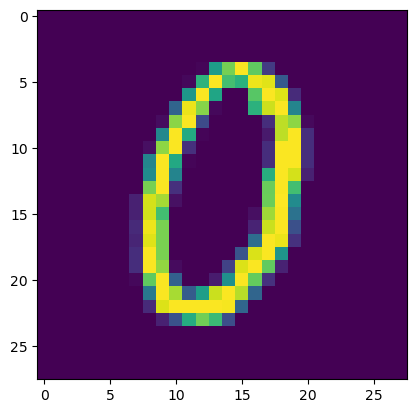

In [82]:
i=0
plt.imshow(X_test[y_pred==i][0].reshape(28,28))
print("Prediction : ", y_pred[y_pred==i][0])